# Lecture 8: Insertion
<html>
<div class="alert alert-info" role="alert" style="margin-top: 10px">
In this exercise we study the FODO cell in more detail.
<ul>
    <li>Collins Insertion</li>
    <li>Dispersion Suppressor</li>
    <li>(Low-$\beta$ insertion)</li>
</ul>
</div>
</html>

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
        <strong>If you use google colab, run this cell:</strong>
    </div>
</html>

<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
<strong>If you run it locally, run</strong>
               </div>
</html>

```bash
$ cd .../pam1-hs2021
...pam1-hs2021$ git pull
```
<html>
    <div class="alert alert-info" style="background-color:rgba(255, 0, 0, 0.6);
                                         margin-top:10px;
                                         color:white;
                                         border-color:rgba(255, 0, 0, 0.3)">
to get the updated repository.</div></html>

As always, we need to set up the general simulation specifications first.
- create a proton particle
- set the kinetic energy to 100 MeV
- set all global variables

In [1]:
from AcceLEGOrator import Proton, Physics, Constants
import AcceLEGOrator.Parameter as param

particle = Proton()

ekin    = 100 #MeV
param.mass    = particle.mass # MeV / c^2
param.charge  = particle.charge # e
param.gamma_0 = Physics.getGamma(ekin, particle.mass)
beta0 = Physics.getBeta(param.gamma_0)
p0 = param.gamma_0 * beta0 * particle.mass   # MeV / c
Brho = p0 / param.charge * 1e6 / Constants.clight # T*m
print('gamma =', param.gamma_0)
print('beta  =', beta0)
print('p     =', p0 , 'MeV/c')
print('Br    =', Brho, 'Tm')

gamma = 1.1065788924789453
beta  = 0.42819548497881543
p     = 444.5834203296386 MeV/c
Br    = 1.4829706634235562 Tm


## Motivation (P2-4 of pam-s8)
We use the thin lens quadrupole for simplicity.

In [2]:
from AcceLEGOrator import ThinQuadrupole, Drift, Tracking
import numpy as np

L = 5 # m
f0 = 4.5 # m

RQ1 = ThinQuadrupole(2.0 * f0) # for half a quadrupole, the focal length is twice that for a full quadrupole
RD  = Drift(L)
RQ2 = ThinQuadrupole(-f0) # vertically focusing quadrupole
cell = [RQ1, RD, RQ2, RD, RQ1]
n_cells = 10
twiss, lengths = Tracking.trackTwiss(cell, n_cells)

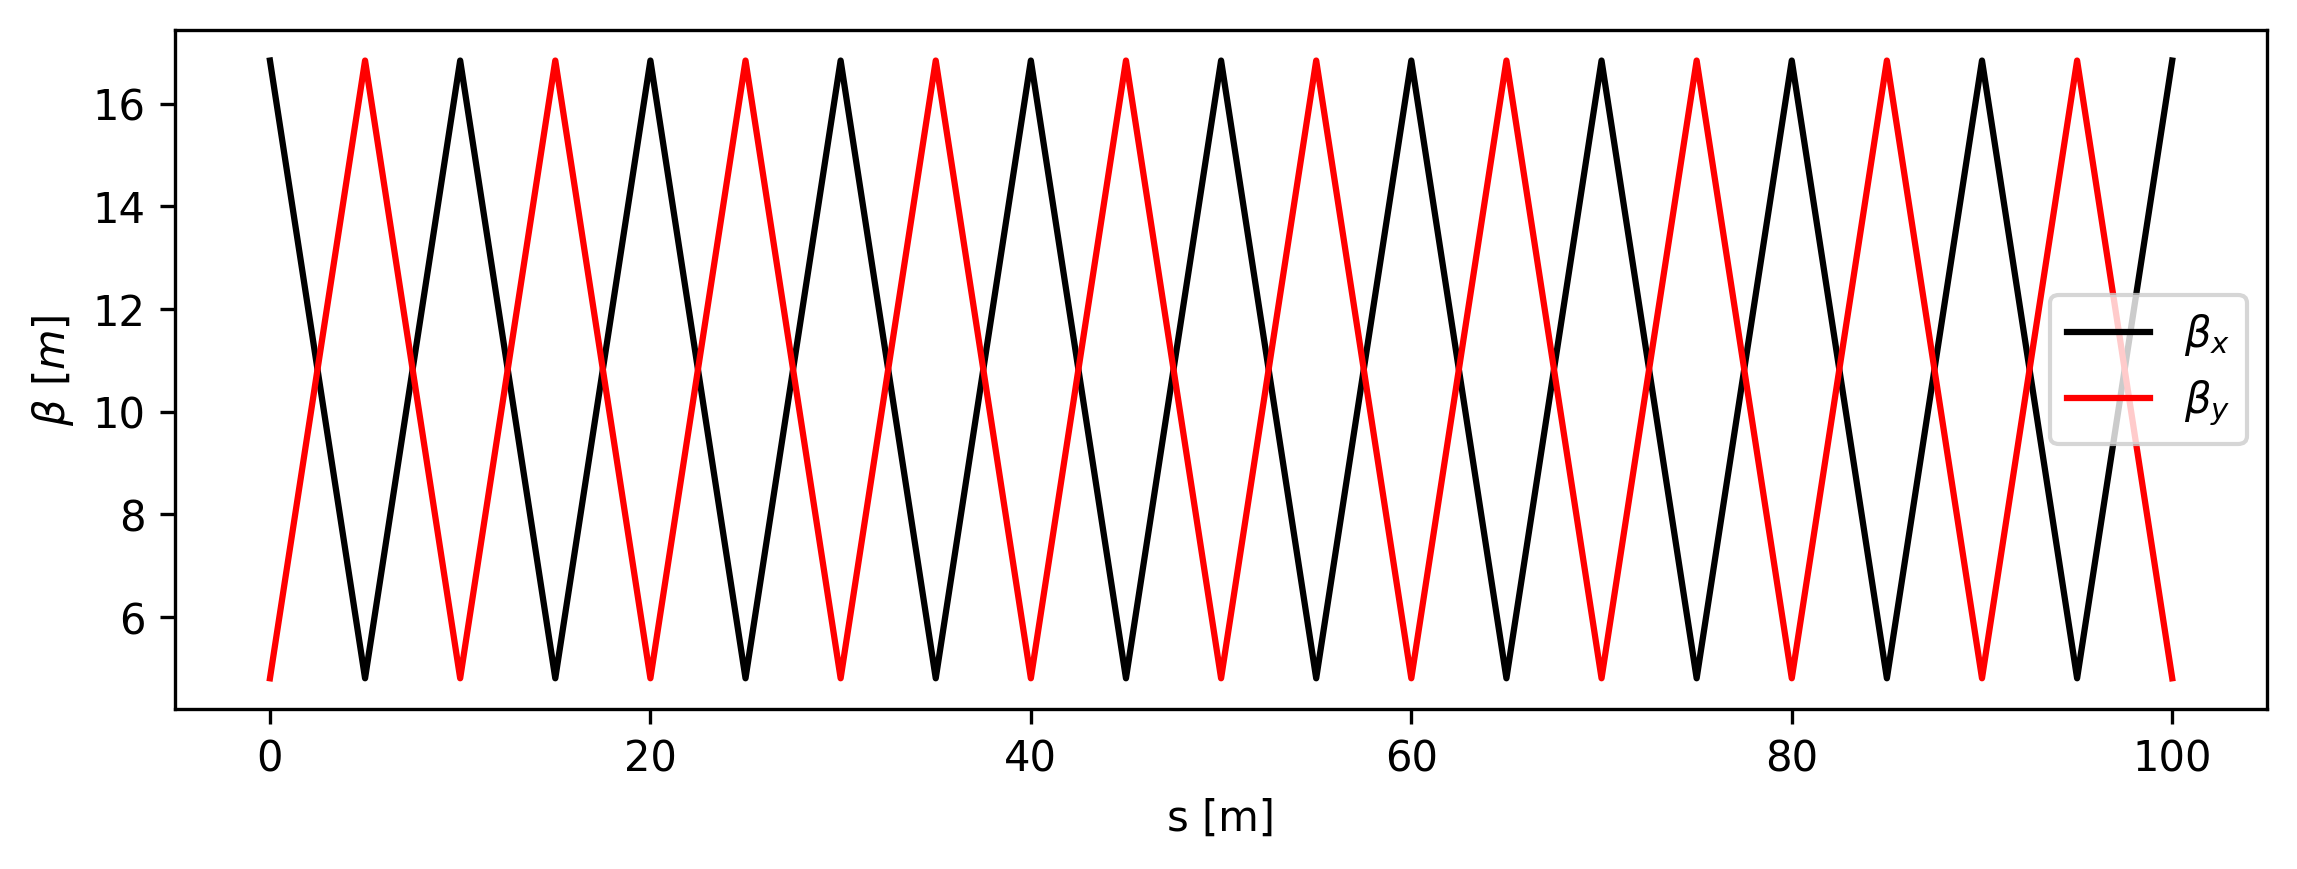

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(dpi=300)
fig.set_size_inches(9,3)
axis = fig.add_subplot(111)
axis.set_xlabel('s [m]')
axis.set_ylabel(r'$\beta\ [m]$')

axis.plot(lengths, twiss[:, 1], label=r'$\beta_x$', color='black')
axis.plot(lengths, twiss[:, 4], label=r'$\beta_y$', color='red')
axis.legend()

plt.show()

## Mismatch
1. Change the drift at s=60m to 7.5m

In [4]:
beamline = cell*n_cells
_indices = [i for i, s in enumerate(lengths) if s==60]
_indices

[29, 30, 31]

In [5]:
beamline[29:32] # all elements at s=60m

In [6]:
beamline[31] = Drift(length=7.5)

2. Use the initial twiss of the previous FODO cell (drift=5m)

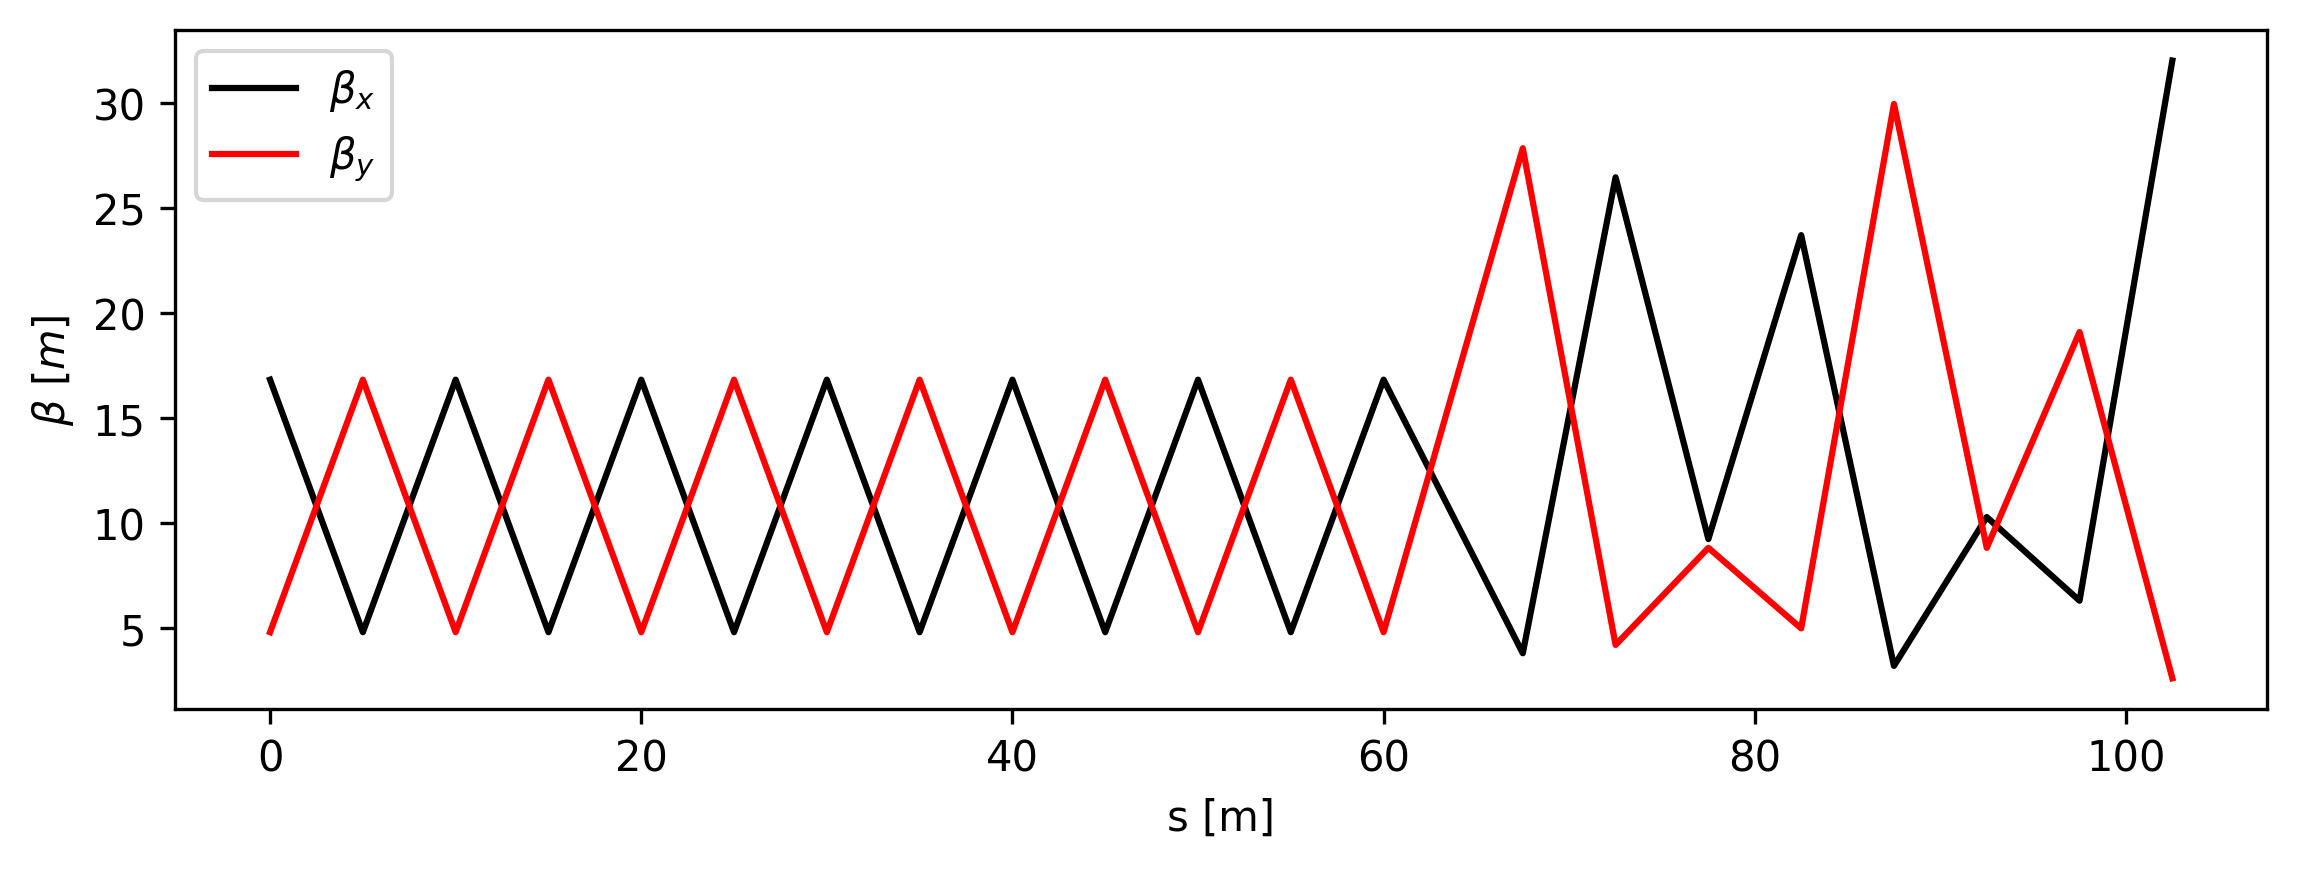

In [7]:
twiss_mis, lengths_mis = Tracking.trackTwiss(beamline, n_cells=1, twiss_init=twiss[0])
fig = plt.figure(dpi=300)
fig.set_size_inches(9,3)
axis = fig.add_subplot(111)
axis.set_xlabel('s [m]')
axis.set_ylabel(r'$\beta\ [m]$')

axis.plot(lengths_mis, twiss_mis[:, 1], label=r'$\beta_x$', color='black')
axis.plot(lengths_mis, twiss_mis[:, 4], label=r'$\beta_y$', color='red')
axis.legend()

plt.show()

2. Use the initial twiss matched with FODO(drift=7.5m).

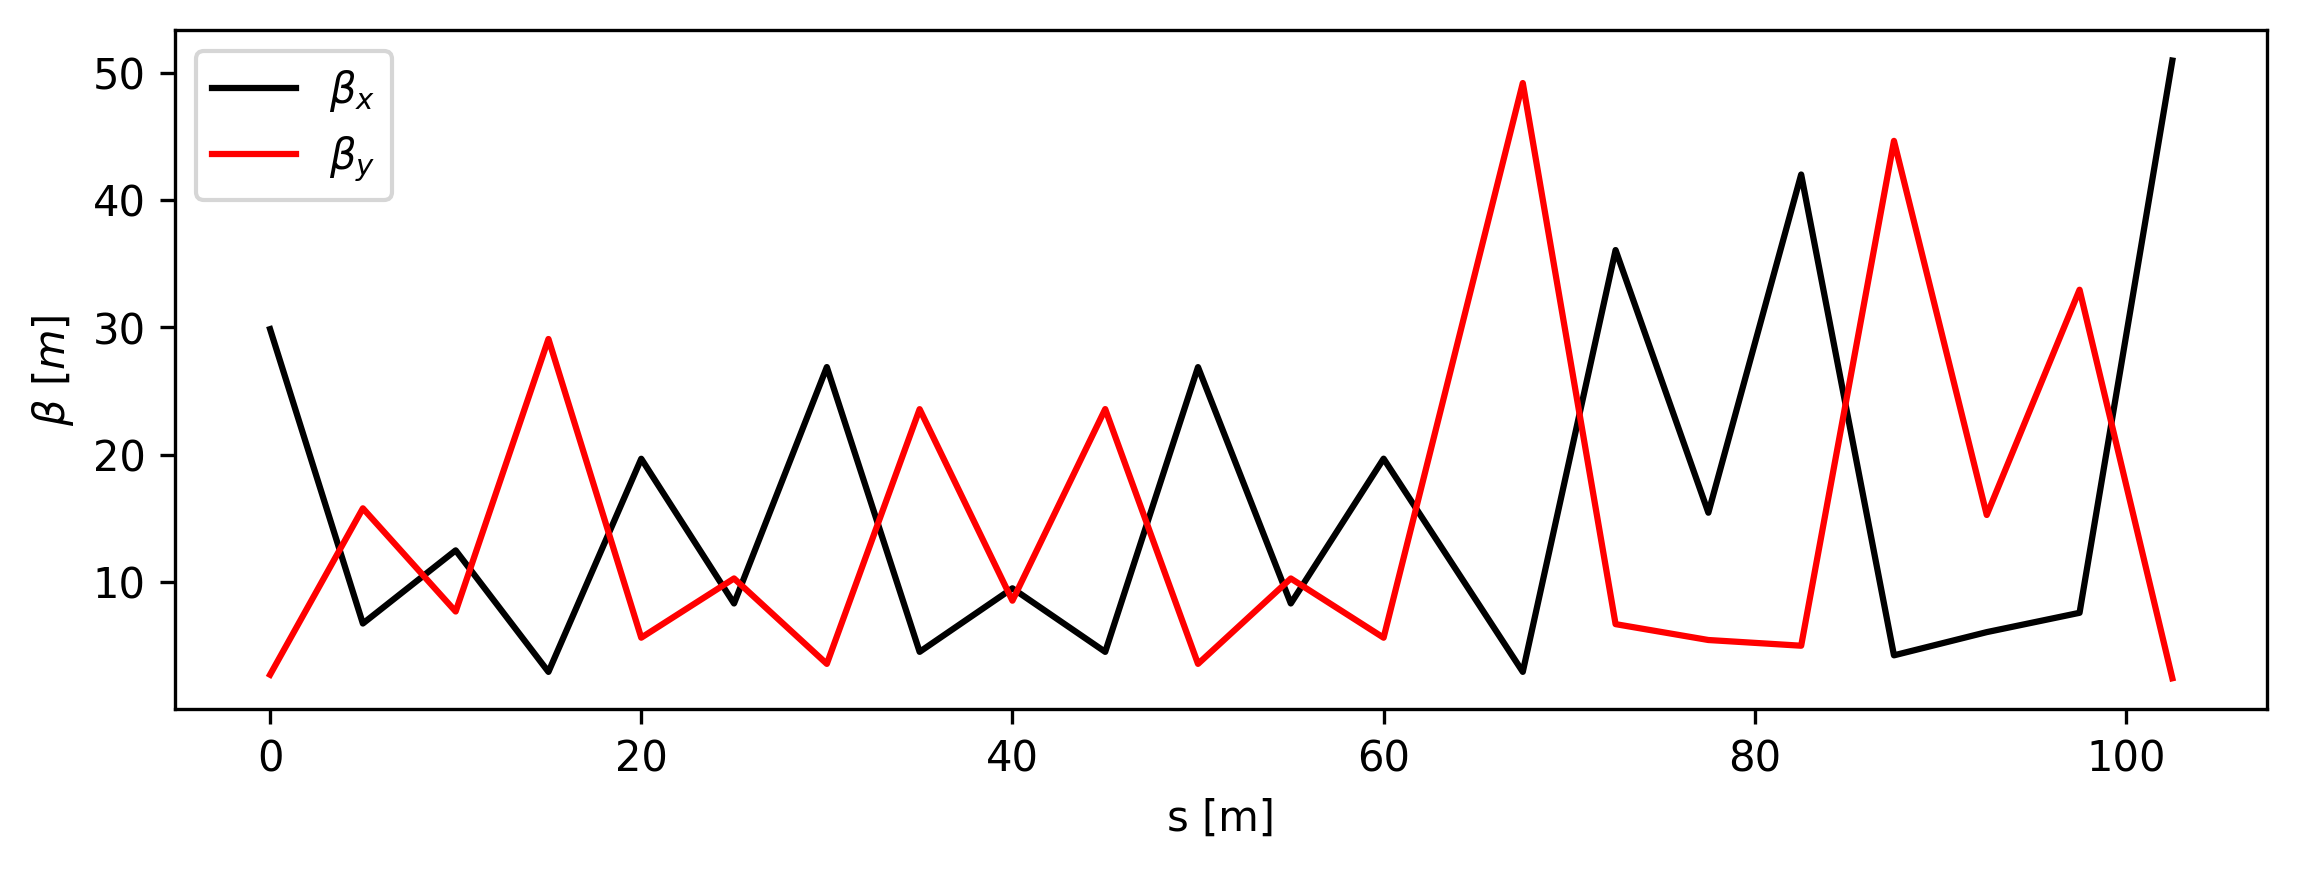

In [8]:
# get initial twiss
cell2 =  [RQ1, Drift(7.5), RQ2, Drift(7.5), RQ1]
ax0, bx0 = Tracking.getTwissInitial(cell2, axis='x')
gx0 = (1 + ax0**2) / bx0

ay0, by0 = Tracking.getTwissInitial(cell2, axis='y')
gy0 = (1 + ay0**2) / by0

# track twiss
twiss_mis2, lengths_mis2 = Tracking.trackTwiss(beamline, n_cells=1, twiss_init=[ax0, bx0, gx0, ay0, by0, gy0])

# plot twiss
fig = plt.figure(dpi=300)
fig.set_size_inches(9,3)
axis = fig.add_subplot(111)
axis.set_xlabel('s [m]')
axis.set_ylabel(r'$\beta\ [m]$')

axis.plot(lengths_mis2, twiss_mis2[:, 1], label=r'$\beta_x$', color='black')
axis.plot(lengths_mis2, twiss_mis2[:, 4], label=r'$\beta_y$', color='red')
axis.legend()

plt.show()

## Dispersion tracking

Dispersion (variation of the horizontal deflection with the energy of the particle)
$$
\begin{align}
\eta_x &:= \frac{x}{\Delta p / P_0} = \frac{x}{\delta} \\
\eta_{x'} &:= \frac{x'}{\Delta p / P_0} = \frac{x'}{\delta}
\end{align}
$$
<html>
<div class="alert alert-info" role="alert" style="margin-top: 10px">
In case of a beamline that consists only of drift spaces, normal quadrupoles and dipoles, we can write the horizontal dispersion by

$$
\begin{equation}
    \begin{pmatrix}
        \eta_{x} \\ \eta_{x'}
    \end{pmatrix}_{s_1}
    =
    \begin{pmatrix}
    R_{11} & R_{12} \\
    R_{21} & R_{22}
    \end{pmatrix}
    \cdot
    \begin{pmatrix}
        \eta_{x} \\ \eta_{x'}
    \end{pmatrix}_{s_0}
    +
    \begin{pmatrix}
        R_{16} \\ R_{26}
    \end{pmatrix}
\end{equation}
$$
where $R$ is the transfer matrix from point $s_0$ in the beamline to point $s_1$
</div>
</html>

You can derive the above relation from
$$
\begin{equation}
\begin{pmatrix}
        x \\ x'
    \end{pmatrix}_{s_1}
    =
    \begin{pmatrix}
    R_{11} & R_{12} \\
    R_{21} & R_{22}
    \end{pmatrix}
    \cdot
    \begin{pmatrix}
        x \\ x'
    \end{pmatrix}_{s_0}
    +
    \begin{pmatrix}
        R_{16} \\ R_{26}
    \end{pmatrix}
    \cdot \delta_{(0)}
\end{equation}
$$

Check the dipole transfer matrix:
![dipole](img/dipole_matrix.png)
Note that $\delta = \delta_0$ because of the last row our the transfer matrix.

More information in: https://indico.cern.ch/event/356897/contributions/1769054/attachments/709973/974586/Lecture4.pdf

[[ 1.          0.          0.        ]
 [-0.11111111  1.          0.        ]
 [ 0.          0.          1.        ]]
[[1. 5. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1.         0.         0.        ]
 [0.22222222 1.         0.        ]
 [0.         0.         1.        ]]
[[1. 5. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 1.          0.          0.        ]
 [-0.11111111  1.          0.        ]
 [ 0.          0.          1.        ]]
[[ 1.          0.          0.        ]
 [-0.11111111  1.          0.        ]
 [ 0.          0.          1.        ]]
[[1. 5. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1.         0.         0.        ]
 [0.22222222 1.         0.        ]
 [0.         0.         1.        ]]
[[1. 5. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 1.          0.          0.        ]
 [-0.11111111  1.          0.        ]
 [ 0.          0.          1.        ]]
[[ 1.          0.          0.        ]
 [-0.11111111  1.          0.        ]
 [ 0.          0.          1.        ]]
[[1. 5. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1.   

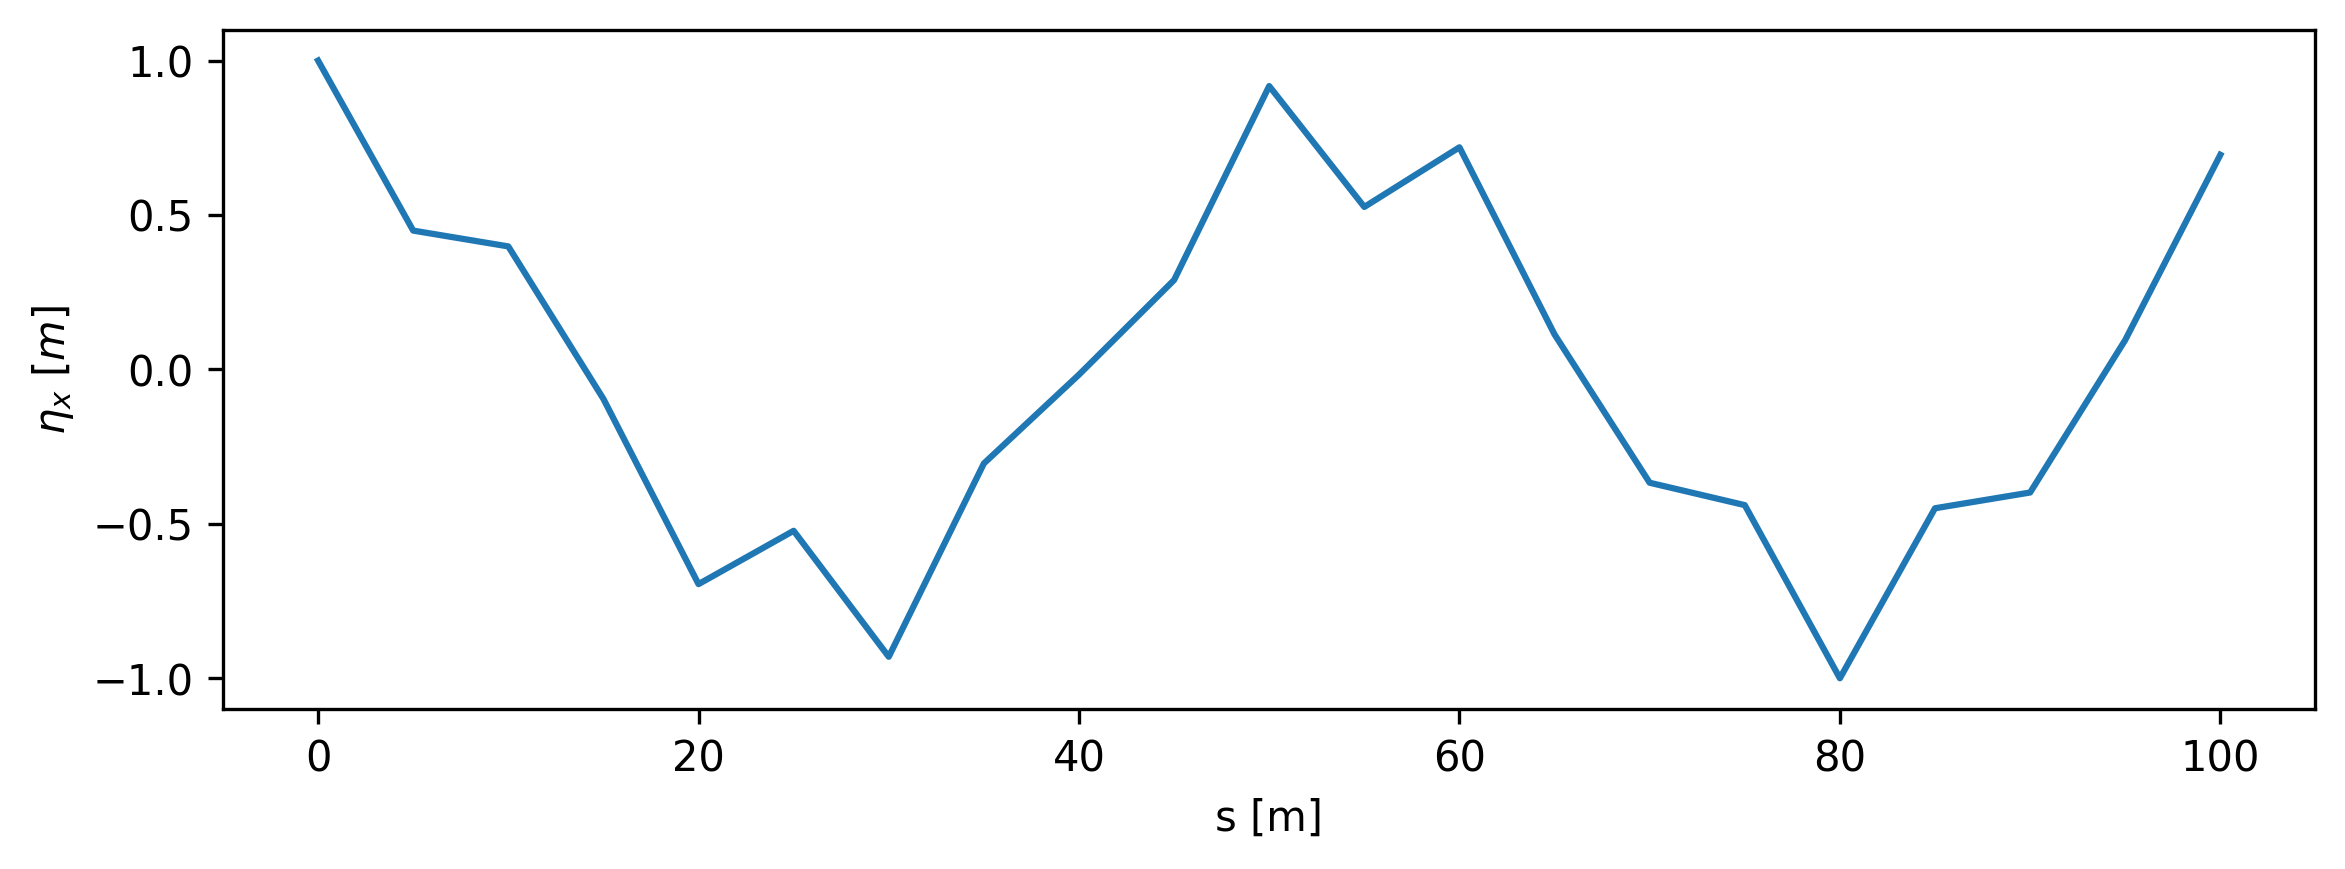

In [16]:
from AcceLEGOrator import Tracking, DipoleRot
dx = 1
dpx = 0.001
dispersion = [dx, dpx, 1]

phi = 5/180*np.pi
cell_rot = [ThinQuadrupole(f0), Drift(L/2), DipoleRot(phi), Drift(L/2),
          ThinQuadrupole(-f0), Drift(L/2), DipoleRot(phi), Drift(L/2)]

dispersions, lengths = Tracking.trackDispersion(dispersion, cell, n_cells=10)

fig = plt.figure(dpi=300)
fig.set_size_inches(9,3)
axis = fig.add_subplot(111)
axis.set_xlabel('s [m]')
axis.set_ylabel(r'$\eta_x\ [m]$')

# plot eta_x
axis.plot(lengths, dispersions[:, 0])

plt.show()

## Collins insertion

#### Write FODO matrix in terms of phase advance (P68-79 of pam-s5)
- The action $J_x$ (Courant-Snyder invariant)
![jx](img/jx.png)
- The angle $\phi_x$
![angle](img/angle.png)
- Phace advance $\Delta \phi_x$
![motion](img/motion.png)
![advance](img/advance.png)
the phase advance over a single cell is the same, no matter what starting point we choose for the cell
- Write FODO cell in terms of phase advance
![fodo_advance](img/fodo_advance.png)
With $\mu_x = \Delta \phi_x$, i.e. phase advance.

In [ ]:
# half beamline
beamline[31] = Drift(20)
beamline_1 = beamline[:32]
beamline_2 = beamline[32:]
twiss_1, lengths_1 = Tracking.trackTwiss(beamline_1, n_cells=1, twiss_init=twiss[0])

# plot twiss
fig = plt.figure(dpi=300)
fig.set_size_inches(9,3)
axis = fig.add_subplot(111)
axis.set_xlabel('s [m]')
axis.set_ylabel(r'$\beta\ [m]$')

axis.plot(lengths_1, twiss_1[:, 1], label=r'$\beta_x$', color='black')
axis.legend()

plt.show()

In [ ]:
# Define the Collins insertion
alpha = twiss_1[-1, 0]
beta = twiss_1[-1, 1]
gamma = (1 + alpha**2) / beta

s1 = 1/gamma # m
s2 = alpha**2/gamma # m
F = -alpha/gamma
print(s1, s2, F)
collins = [Drift(s1), ThinQuadrupole(-F), Drift(s2), ThinQuadrupole(F), Drift(s1)]

In [ ]:
beamline_collins = collins + beamline_2
# track twiss
twiss_collins, lengths_collins = Tracking.trackTwiss(beamline_collins, n_cells=1,
                                                     twiss_init=twiss_1[-1])
for i in range(len(lengths_collins)):
    lengths_collins[i] += lengths_1[-1]
    
# plot twiss
fig = plt.figure(dpi=300)
fig.set_size_inches(9,3)
axis = fig.add_subplot(111)
axis.set_xlabel('s [m]')
axis.set_ylabel(r'$\beta\ [m]$')

axis.plot(np.concatenate([lengths_1, lengths_collins]), 
          np.concatenate([twiss_1[:, 1], twiss_collins[:, 1]]), label=r'$\beta_x$', color='black')
axis.legend()

plt.show()

In [ ]:
beamline_full = beamline_1 + beamline_collins
dx =0.01
dpx = 0.01
dispersion = [dx, dpx, 1]

dispersions_full, lengths_full = Tracking.trackDispersion(dispersion, beamline_full, n_cells=1)

fig = plt.figure(dpi=300)
fig.set_size_inches(9,3)
axis = fig.add_subplot(111)
axis.set_xlabel('s [m]')
axis.set_ylabel(r'$\eta_x\ [m]$')

# plot eta_x
axis.plot(lengths_full, np.abs(dispersions_full[:, 0]))

plt.show()

## Dispersion Supressor

In [ ]:
from AcceLEGOrator import DipoleRot

phi = 5/180*np.pi
cell_rot = [ThinQuadrupole(f0), Drift(L/2), DipoleRot(phi), Drift(L/2),
          ThinQuadrupole(-f0), Drift(L/2), DipoleRot(phi), Drift(L/2)]
phi_1 = 0
phi_2 = phi
cell_1 = [ThinQuadrupole(f0), Drift(L/2),DipoleRot(phi_1), Drift(L/2),
          ThinQuadrupole(-f0), Drift(L/2), DipoleRot(phi_1), Drift(L/2)]
cell_2 = [ThinQuadrupole(f0), Drift(L/2), DipoleRot(phi_2), Drift(L/2),
          ThinQuadrupole(-f0), Drift(L/2), DipoleRot(phi_2), Drift(L/2)]

In [ ]:
dx = 0
dpx = 0.01
dispersion = [dx, dpx, 1]

beamline_sup = cell_rot*6 +  cell_1 + cell_2 + [Drift(20)] + cell_2 + cell_1 + cell_rot*6
dispersions_sup, lengths_sup = Tracking.trackDispersion(dispersion, beamline_sup, n_cells=1)

fig = plt.figure(dpi=300)
fig.set_size_inches(9,3)
axis = fig.add_subplot(111)
axis.set_xlabel('s [m]')
axis.set_ylabel(r'$\eta_x\ [m]$')
axis.axhline(y=0, color='black')
# plot eta_x
axis.plot(lengths_sup, dispersions_sup[:, 0])

plt.show()

## Low-$\beta$ insertion

![ip](img/ip.jpeg)